In [1]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77
ALPHA = 0.1  #non-IID

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ---- MODERATE NON-IID PARTITION (DIRICHLET) ----
labels = np.array([sample[1] for sample in train_dataset])
num_classes = len(train_dataset.classes)
class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

client_indices = [[] for _ in range(NUM_CLIENTS)]
np.random.seed(SEED)

for c, idxs in enumerate(class_indices):
    # Sample proportions for each client using Dirichlet
    proportions = np.random.dirichlet(np.repeat(ALPHA, NUM_CLIENTS))
    # Adjust for rounding errors
    proportions = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
    split_idxs = np.split(np.random.permutation(idxs), proportions)
    for client, idx in enumerate(split_idxs):
        client_indices[client].extend(idx)

# Shuffle indices for each client, then create subsets
client_subsets = []
for indices in client_indices:
    indices = np.array(indices)
    np.random.shuffle(indices)
    subset = torch.utils.data.Subset(train_dataset, indices.tolist())
    client_subsets.append(subset)
    print(f"Client {len(client_subsets)-1} train samples: {len(subset)}")

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- CLASS BREAKDOWN FOR EACH CLIENT ----
class_names = train_dataset.classes
for idx, (client_train, _) in enumerate(client_data):
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)
for idx, (client_train, client_test) in enumerate(client_data):
    # Train split breakdown
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    train_counts = {class_name: train_labels.count(i) for i, class_name in enumerate(class_names)}

    # Test split breakdown
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    test_counts = {class_name: test_labels.count(i) for i, class_name in enumerate(class_names)}

    print(f"Client {idx}:")
    print("  Training set:")
    for class_name in class_names:
        print(f"    {class_name}: {train_counts[class_name]} samples")
    print("  Testing set:")
    for class_name in class_names:
        print(f"    {class_name}: {test_counts[class_name]} samples")
    print("-" * 30)



Train samples: 5712, Test samples: 1311
Client 0 train samples: 2278
Client 1 train samples: 670
Client 2 train samples: 1173
Client 3 train samples: 1591
Client train: 1823, test: 455
Client train: 536, test: 134
Client train: 939, test: 234
Client train: 1273, test: 318
Client 0:
  glioma: 926 samples
  meningioma: 53 samples
  notumor: 0 samples
  pituitary: 844 samples
------------------------------
Client 1:
  glioma: 125 samples
  meningioma: 411 samples
  notumor: 0 samples
  pituitary: 0 samples
------------------------------
Client 2:
  glioma: 0 samples
  meningioma: 609 samples
  notumor: 7 samples
  pituitary: 323 samples
------------------------------
Client 3:
  glioma: 1 samples
  meningioma: 1 samples
  notumor: 1270 samples
  pituitary: 1 samples
------------------------------
Client 0:
  Training set:
    glioma: 926 samples
    meningioma: 53 samples
    notumor: 0 samples
    pituitary: 844 samples
  Testing set:
    glioma: 238 samples
    meningioma: 12 samples
  

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(client_subsets, class_names, alpha_value):
    num_clients = len(client_subsets)
    num_classes = len(class_names)

    # Count per-class samples for each client
    dist_matrix = np.zeros((num_clients, num_classes), dtype=int)

    for client_id, subset in enumerate(client_subsets):
        labels = [subset[i][1] for i in range(len(subset))]
        for cls in range(num_classes):
            dist_matrix[client_id, cls] = labels.count(cls)

    # ----------- Plot Bar Chart -----------
    x = np.arange(num_clients)
    width = 0.2   # width of each bar

    plt.figure(figsize=(10,5))
    
    for cls in range(num_classes):
        plt.bar(x + cls*width, dist_matrix[:, cls], width, label=class_names[cls])

    plt.xticks(x + width, [f"client_{i}" for i in range(num_clients)])
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution (Dirichlet α = {alpha_value})")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.show()

    return dist_matrix


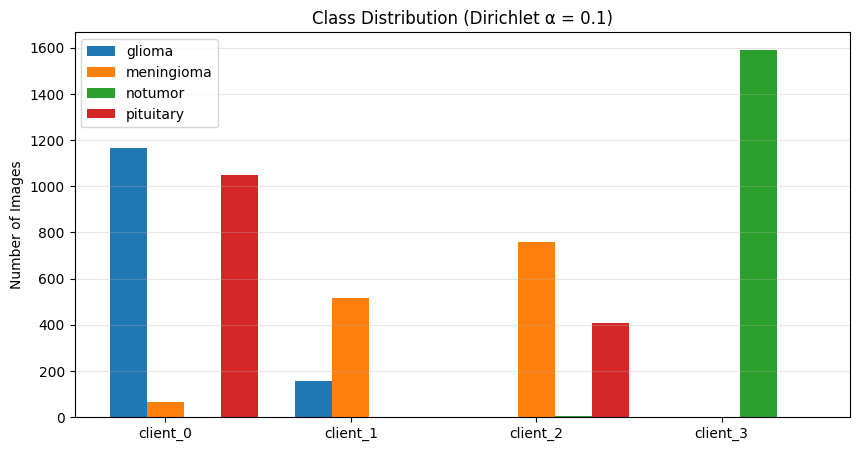

In [5]:
dist_extreme = plot_class_distribution(client_subsets, class_names, alpha_value=0.1)


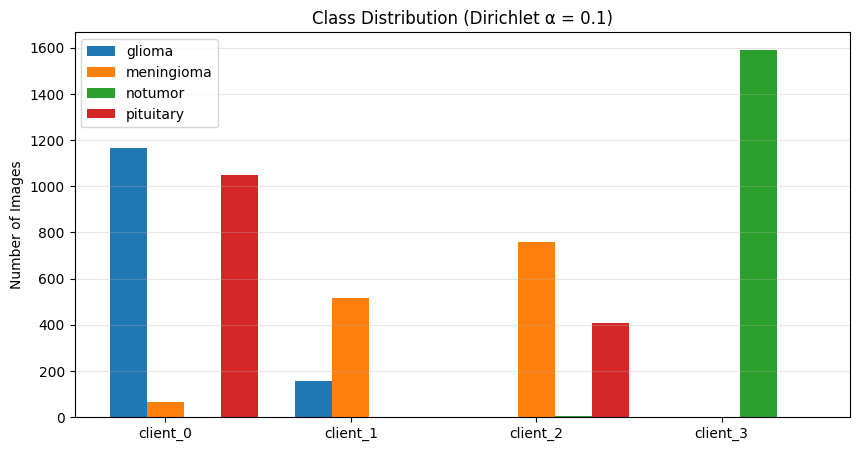

In [3]:
dist_extreme = plot_class_distribution(client_subsets, class_names, alpha_value=0.1)


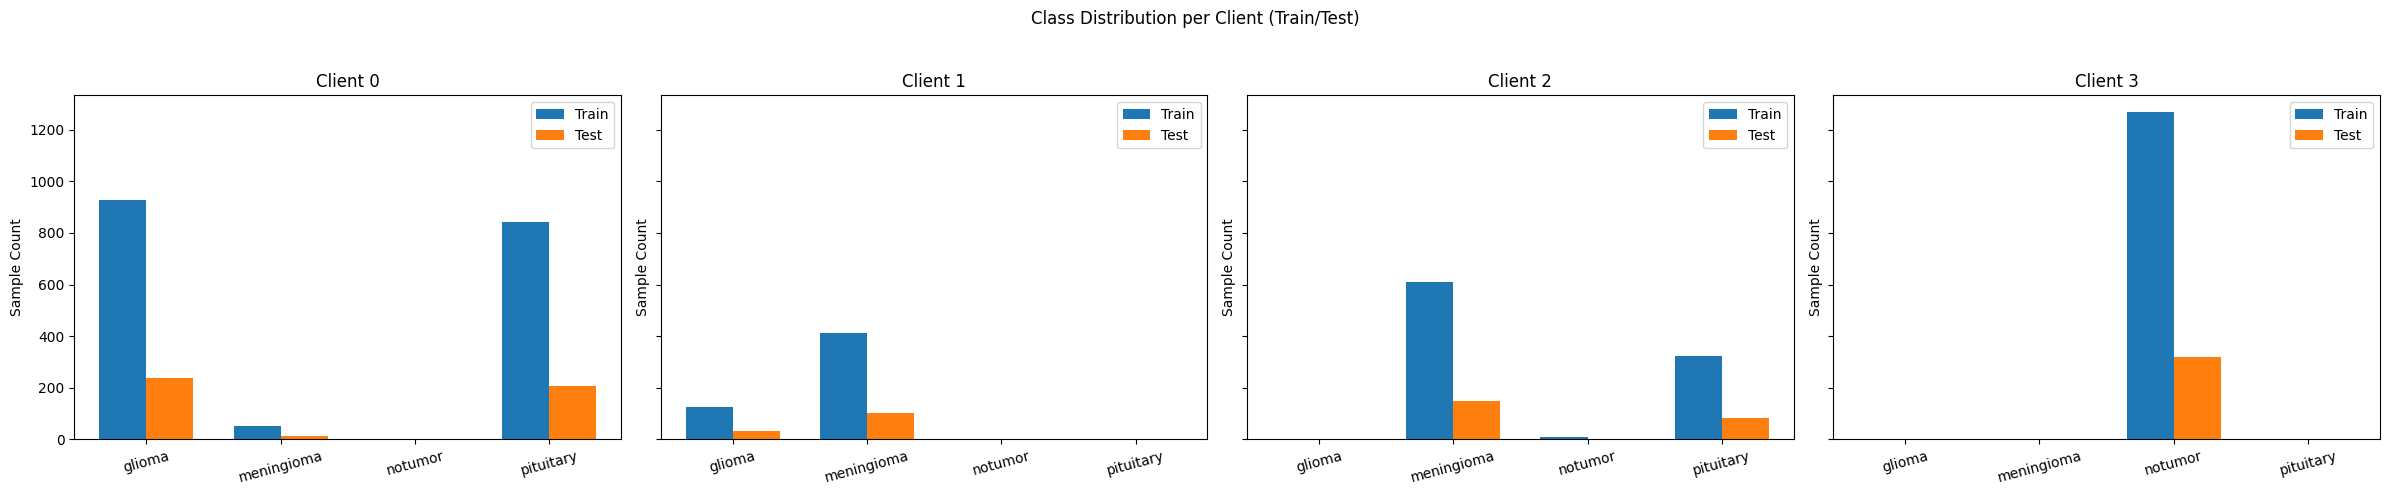

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# ---- PREPARE DATA FOR PLOTTING ----
client_train_counts = []
client_test_counts = []

for idx, (client_train, client_test) in enumerate(client_data):
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    train_counts = [train_labels.count(i) for i in range(len(class_names))]
    test_counts = [test_labels.count(i) for i in range(len(class_names))]
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

# ---- GROUPED BAR CHART FOR EACH CLIENT ----
num_classes = len(class_names)
num_clients = len(client_data)
x = np.arange(num_classes)  # the label locations

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
# Each subplot is for one client
for idx in range(num_clients):
    width = 0.35
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label='Train', color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label='Test', color='tab:orange')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_ylabel('Sample Count')
    axs[idx].set_title(f'Client {idx}')
    axs[idx].legend()

plt.suptitle('Class Distribution per Client (Train/Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


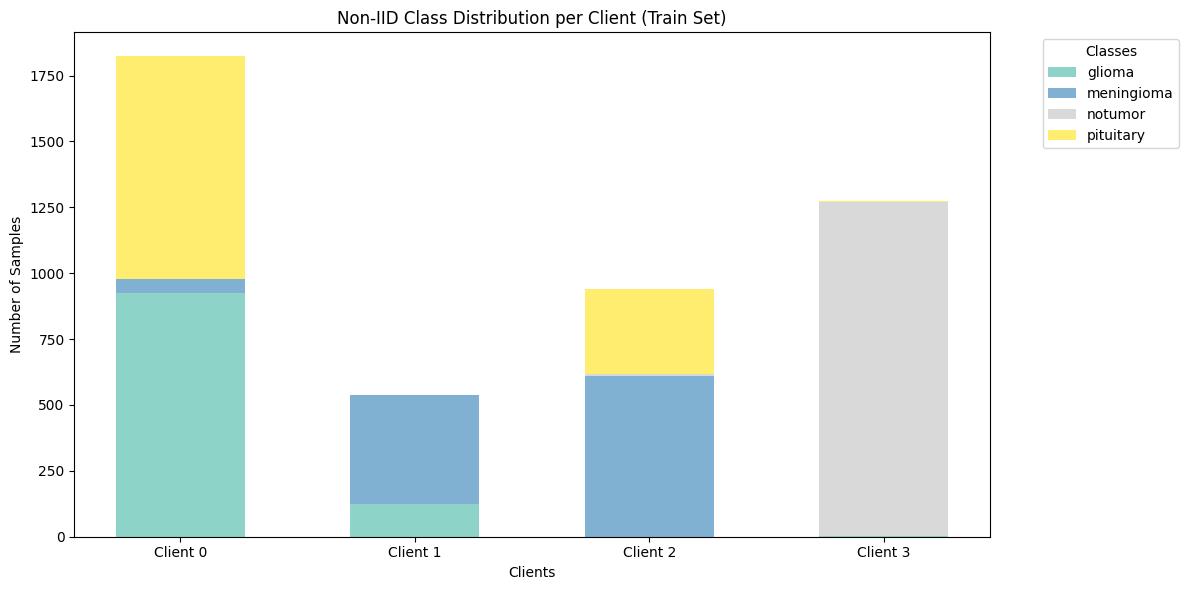

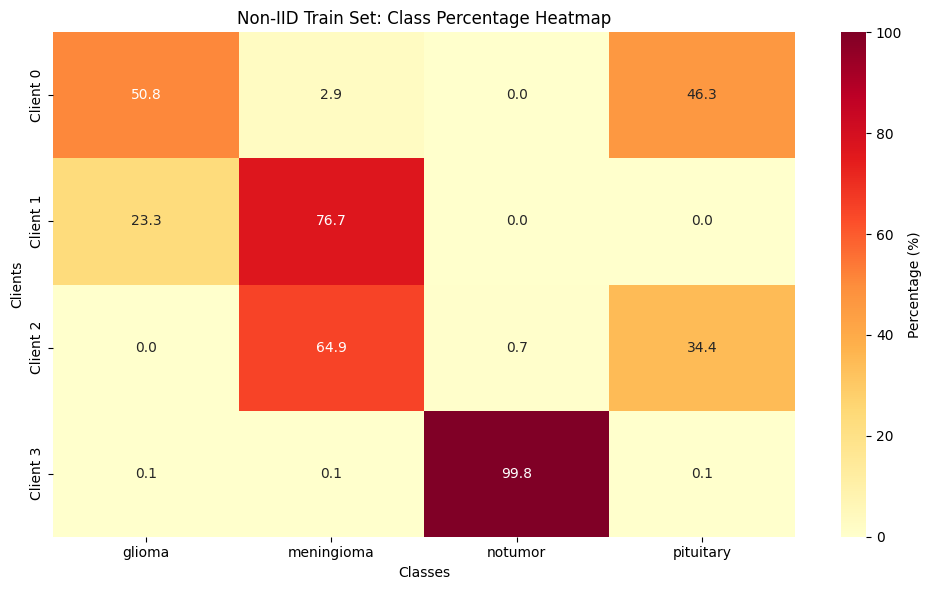

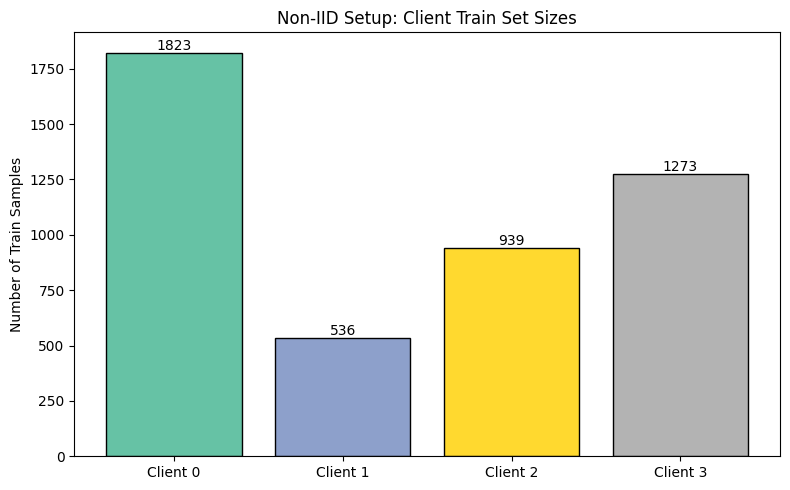

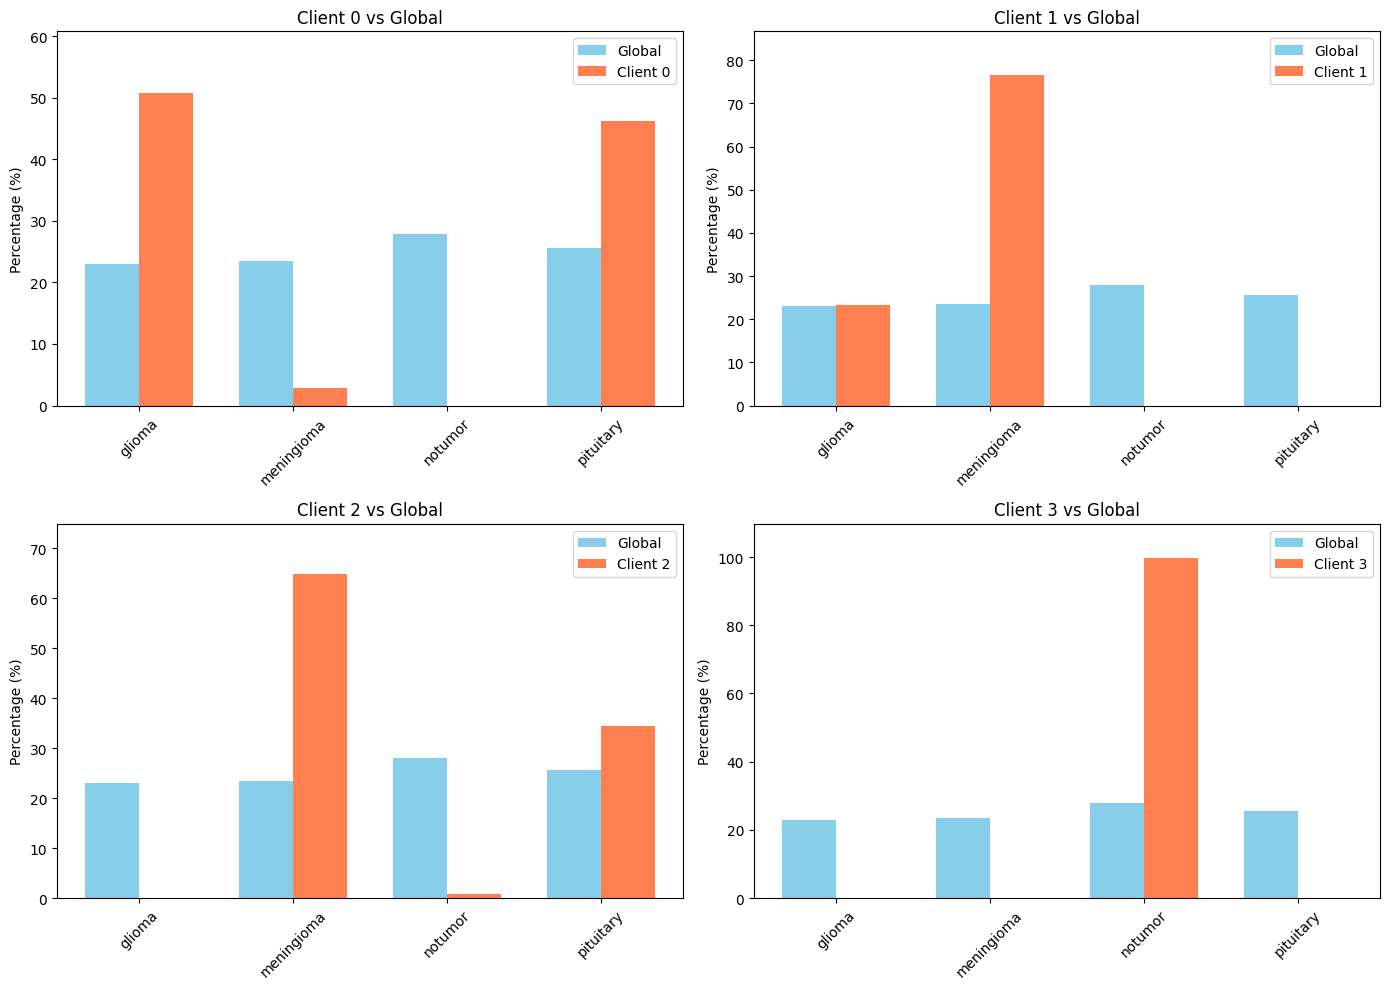


NON-IID DATA DISTRIBUTION SUMMARY (Train)

Client 0: 1823 samples
  glioma: 926 (50.8%)
  meningioma: 53 (2.9%)
  notumor: 0 (0.0%)
  pituitary: 844 (46.3%)

Client 1: 536 samples
  glioma: 125 (23.3%)
  meningioma: 411 (76.7%)
  notumor: 0 (0.0%)
  pituitary: 0 (0.0%)

Client 2: 939 samples
  glioma: 0 (0.0%)
  meningioma: 609 (64.9%)
  notumor: 7 (0.7%)
  pituitary: 323 (34.4%)

Client 3: 1273 samples
  glioma: 1 (0.1%)
  meningioma: 1 (0.1%)
  notumor: 1270 (99.8%)
  pituitary: 1 (0.1%)

Global Distribution (Train Set):
  glioma: 1052 (23.0%)
  meningioma: 1074 (23.5%)
  notumor: 1277 (27.9%)
  pituitary: 1168 (25.6%)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# ----- 1. Collect train set class counts for each client -----
client_class_dist = []
for client_train, _ in client_data:  # only train split
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = [labels.count(i) for i in range(len(class_names))]
    client_class_dist.append(counts)

num_clients = len(client_class_dist)
num_classes = len(class_names)

# ----- 2. Stacked bar chart: class samples per client -----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_clients)
bottom = np.zeros(num_clients)
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

for class_idx in range(num_classes):
    values = [client_class_dist[cidx][class_idx] for cidx in range(num_clients)]
    ax.bar(x, values, bottom=bottom, width=0.55, color=colors[class_idx], label=class_names[class_idx])
    bottom += np.array(values)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {i}" for i in range(num_clients)])
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Clients")
ax.set_title("Non-IID Class Distribution per Client (Train Set)")
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----- 3. Heatmap: class percentage per client -----
heatmap_data = []
for counts in client_class_dist:
    total = sum(counts)
    row = [100 * c / total if total > 0 else 0 for c in counts]
    heatmap_data.append(row)
heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Percentage (%)'},
            xticklabels=class_names, yticklabels=[f"Client {i}" for i in range(num_clients)], ax=ax, vmin=0, vmax=100)
ax.set_title("Non-IID Train Set: Class Percentage Heatmap")
ax.set_xlabel("Classes")
ax.set_ylabel("Clients")
plt.tight_layout()
plt.show()

# ----- 4. Bar chart: client train set sizes -----
client_sizes = [sum(counts) for counts in client_class_dist]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar([f"Client {i}" for i in range(num_clients)], client_sizes, color=plt.cm.Set2(np.linspace(0,1,num_clients)), edgecolor='black')
ax.set_ylabel("Number of Train Samples")
ax.set_title("Non-IID Setup: Client Train Set Sizes")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ----- 5. Comparison: global distribution vs client -----
global_counts = [0 for _ in range(num_classes)]
for client_train, _ in client_data:
    labels = [client_train[i][1] for i in range(len(client_train))]
    for i in labels:
        global_counts[i] += 1
global_total = sum(global_counts)
global_percentages = [100 * c / global_total for c in global_counts]

fig, axes = plt.subplots(2, (num_clients+1)//2, figsize=(14, 10))
axes = axes.flatten()
for idx in range(num_clients):
    client_total = sum(client_class_dist[idx])
    client_percentages = [100 * n / client_total if client_total > 0 else 0 for n in client_class_dist[idx]]
    x_pos = np.arange(num_classes)
    width = 0.35
    axes[idx].bar(x_pos - width/2, global_percentages, width, label='Global', color='skyblue')
    axes[idx].bar(x_pos + width/2, client_percentages, width, label=f'Client {idx}', color='coral')
    axes[idx].set_title(f"Client {idx} vs Global")
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend()
    axes[idx].set_ylim([0, max(global_percentages + client_percentages) + 10])
plt.tight_layout()
plt.show()

# ----- 6. Summary statistics -----
print("\n" + "="*50)
print("NON-IID DATA DISTRIBUTION SUMMARY (Train)")
print("="*50)
for idx, counts in enumerate(client_class_dist):
    client_total = sum(counts)
    print(f"\nClient {idx}: {client_total} samples")
    for class_idx, class_name in enumerate(class_names):
        pct = 100 * counts[class_idx] / client_total if client_total > 0 else 0
        print(f"  {class_name}: {counts[class_idx]} ({pct:.1f}%)")

print("\n" + "="*50)
print("Global Distribution (Train Set):")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    pct = 100 * global_counts[class_idx] / global_total if global_total > 0 else 0
    print(f"  {class_name}: {global_counts[class_idx]} ({pct:.1f}%)")
print("="*50)


In [6]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# ----- 1. Prepare class distributions -----

# Get number of classes
num_classes = len(train_dataset.classes)

# Extract class distributions for each client
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]  # (filename, class_idx)
        counts[class_idx] += 1
    # Normalize to probabilities
    if counts.sum() > 0:
        prob_vec = counts / counts.sum()
    else:
        prob_vec = counts
    client_distributions.append(prob_vec)

# ----- 2. Compute global class distribution -----
global_counts = np.zeros(num_classes)
for sample in train_dataset.samples:
    class_idx = sample[1]
    global_counts[class_idx] += 1
global_dist = global_counts / global_counts.sum()

print("Global Distribution:", global_dist)
print("Classes:", train_dataset.classes)

# ----- 3. Compute Jensen-Shannon Divergence (JS Divergence) -----
print("\n" + "="*70)
print("JENSEN-SHANNON DIVERGENCE (Client vs Global)")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)\n")

js_divergences = []
for k, client_dist in enumerate(client_distributions):
    js_div = jensenshannon(global_dist, client_dist)
    js_divergences.append(js_div)
    print(f"Client {k}: JS Divergence = {js_div:.4f}")

avg_js = np.mean(js_divergences)
print(f"\nAverage JS Divergence: {avg_js:.4f}")


Global Distribution: [0.23126751 0.23441877 0.27923669 0.25507703]
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

JENSEN-SHANNON DIVERGENCE (Client vs Global)
Range: 0 (identical) to 1 (completely different)

Client 0: JS Divergence = 0.4298
Client 1: JS Divergence = 0.5097
Client 2: JS Divergence = 0.4672
Client 3: JS Divergence = 0.5926

Average JS Divergence: 0.4998


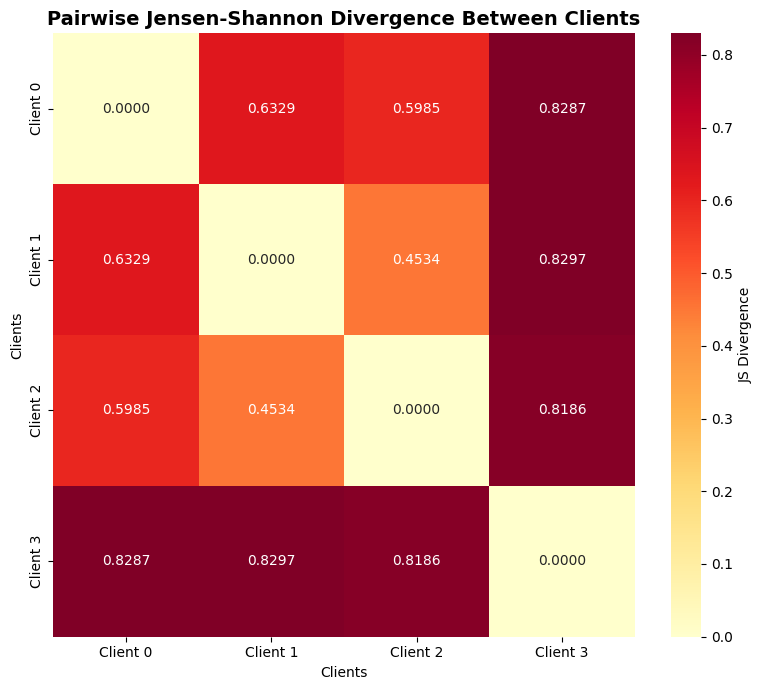

In [7]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# ----- 1. Prepare client class probability distributions -----
num_classes = len(train_dataset.classes)
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]
        counts[class_idx] += 1
    prob_vec = counts / counts.sum() if counts.sum() > 0 else counts
    client_distributions.append(prob_vec)

# ----- 2. Compute pairwise JS divergence matrix -----
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS))
for i in range(NUM_CLIENTS):
    for j in range(NUM_CLIENTS):
        pairwise_js[i, j] = jensenshannon(client_distributions[i], client_distributions[j])

# ----- 3. Plot pairwise JS divergence heatmap -----
plt.figure(figsize=(8, 7))
sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
            xticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            yticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            cbar_kws={'label': 'JS Divergence'})
plt.title('Pairwise Jensen-Shannon Divergence Between Clients', fontsize=14, fontweight='bold')
plt.xlabel('Clients')
plt.ylabel('Clients')
plt.tight_layout()
plt.show()


In [9]:
import torch
print("MPS available:", torch.backends.mps.is_available())


MPS available: True


In [45]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset

# ============================================================
#                      DEVICE SETUP
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥 Using CPU")

# ============================================================
#                      CONFIG
# ============================================================
SEED = 77
NUM_ROUNDS = 30
LOCAL_EPOCHS = 5
LR = 3e-4
BATCH_SIZE = 32

NUM_CLIENTS = len(client_indices)     # from your extreme non-IID partition
NUM_CLASSES = len(train_dataset.classes)

# ============================================================
#                      REPRODUCIBILITY
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#               CLIENT DATA LOADERS (extreme non-IID)
# ============================================================
client_loaders = {}

for k in range(NUM_CLIENTS):
    subset = Subset(train_dataset, client_indices[k])
    client_loaders[k] = DataLoader(
        subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

# Holdout (10%)
holdout_indices = np.random.choice(len(train_dataset), int(0.1 * len(train_dataset)), replace=False)
holdout_loader = DataLoader(
    Subset(train_dataset, holdout_indices),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# ============================================================
#      RESNET18 (PRETRAINED) WITH FREEZING STRATEGY
# ============================================================
def create_pretrained_resnet18(num_classes):

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze first layers
    for param in model.conv1.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False

    # Fine-tune only deeper layers
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace classifier head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
#                TRAINING & EVALUATION
# ============================================================
def train_one_epoch(model, loader, device, optimizer):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = crit_ce(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss/max(total,1), "acc": total_correct/max(total,1)}


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss/max(total,1), "acc": total_correct/max(total,1)}

# ============================================================
#                FEDAVG MAIN LOOP
# ============================================================
global_model = create_pretrained_resnet18(NUM_CLASSES).to(DEVICE)

best_global_acc = -1
best_global_state = None

metrics_history_fedavg_pretrained_extreme = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS)}
}

for rnd in range(NUM_ROUNDS):
    print(f"\n🔁 -------- Round {rnd+1}/{NUM_ROUNDS} --------")

    local_states = []

    # ---------- Local Client Training ----------
    for k in range(NUM_CLIENTS):

        local_model = copy.deepcopy(global_model).to(DEVICE)
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, local_model.parameters()), lr=LR)

        for ep in range(LOCAL_EPOCHS):
            train_one_epoch(local_model, client_loaders[k], DEVICE, optimizer)

        local_states.append({n: p.cpu() for n, p in local_model.state_dict().items()})

        client_metric = evaluate(local_model, client_loaders[k], DEVICE)
        metrics_history_fedavg_pretrained_extreme["clients"][k].append(client_metric)

        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")

    # ---------- FedAvg Aggregation ----------
    new_state = {}
    for key in global_model.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

    # Only average floating tensors
        if stacked.dtype in (torch.float32, torch.float64, torch.float16, torch.bfloat16):
            new_state[key] = stacked.mean(dim=0)
        else:
        # For int/bool tensors (e.g., num_batches_tracked), copy from client 0
            new_state[key] = stacked[0]


    global_model.load_state_dict(new_state)

    # ---------- Holdout Evaluation ----------
    holdout_metric = evaluate(global_model, holdout_loader, DEVICE)
    metrics_history_fedavg_pretrained_extreme["round"].append(rnd + 1)
    metrics_history_fedavg_pretrained_extreme["holdout"].append(holdout_metric)

    print(f"🌍 Global Holdout | Loss: {holdout_metric['loss']:.4f} | Acc: {holdout_metric['acc']:.4f}")

    # ---------- Save Best Model ----------
    if holdout_metric["acc"] > best_global_acc:
        best_global_acc = holdout_metric["acc"]
        best_global_state = copy.deepcopy(global_model.state_dict())
        print(f"💾 New Best Model Saved! Acc = {best_global_acc:.4f}")

# ============================================================
#                   SAVE OUTPUTS
# ============================================================
# Save best model
torch.save(best_global_state, "best_global_model_fedavg_pretrained_extreme.pth")
print("\n✅ Saved: best_global_model_fedavg_pretrained_extreme.pth")

# Save metrics
np.save("metrics_history_fedavg_pretrained_extreme.npy", metrics_history_fedavg_pretrained_extreme)
print("📊 Saved: metrics_history_fedavg_pretrained_extreme.npy")


🚀 Using Apple Silicon GPU (MPS)

🔁 -------- Round 1/30 --------
  Client 0 | Acc: 1.0000
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 1.0000
  Client 3 | Acc: 1.0000
🌍 Global Holdout | Loss: 1.0315 | Acc: 0.6462
💾 New Best Model Saved! Acc = 0.6462

🔁 -------- Round 2/30 --------
  Client 0 | Acc: 1.0000
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 1.0000
  Client 3 | Acc: 1.0000
🌍 Global Holdout | Loss: 1.0638 | Acc: 0.5149

🔁 -------- Round 3/30 --------
  Client 0 | Acc: 1.0000
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 1.0000
  Client 3 | Acc: 1.0000
🌍 Global Holdout | Loss: 1.0036 | Acc: 0.6235

🔁 -------- Round 4/30 --------
  Client 0 | Acc: 0.9996
  Client 1 | Acc: 0.9970
  Client 2 | Acc: 0.9812
  Client 3 | Acc: 1.0000
🌍 Global Holdout | Loss: 0.9626 | Acc: 0.6690
💾 New Best Model Saved! Acc = 0.6690

🔁 -------- Round 5/30 --------
  Client 0 | Acc: 1.0000
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 0.9991
  Client 3 | Acc: 1.0000
🌍 Global Holdout | Loss: 0.9549 | Acc: 0.5236

🔁 -

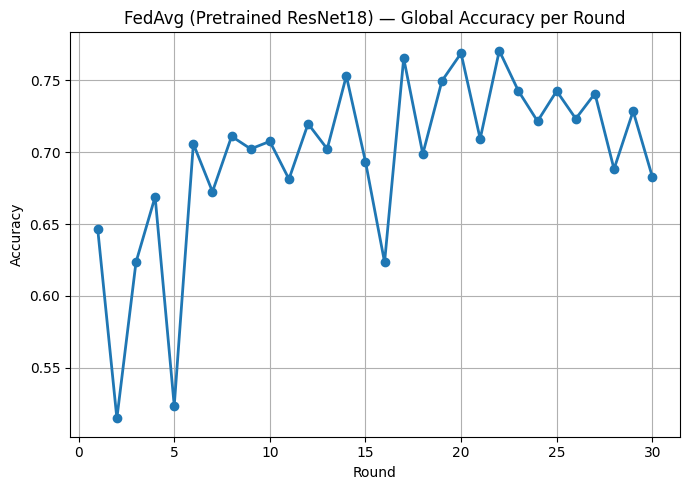

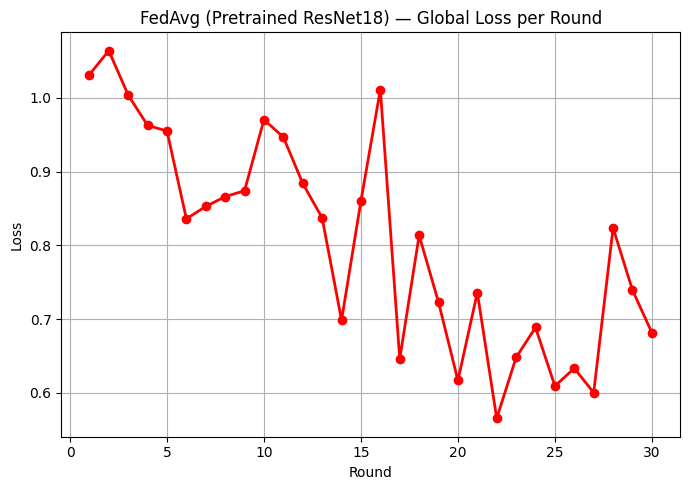

Saved: fedavg_pretrained_rounds.npy, fedavg_pretrained_acc.npy, fedavg_pretrained_loss.npy


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
#  LOAD METRICS FROM FEDAVG PRETRAINED EXPERIMENT
# ============================================================

rounds = metrics_history_fedavg_pretrained_extreme["round"]
holdout_metrics = metrics_history_fedavg_pretrained_extreme["holdout"]

accs = [m["acc"] for m in holdout_metrics]
losses = [m["loss"] for m in holdout_metrics]

# ============================================================
#                PLOT ACCURACY OVER ROUNDS
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(rounds, accs, marker='o', linewidth=2)
plt.title("FedAvg (Pretrained ResNet18) — Global Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
#                PLOT LOSS OVER ROUNDS
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(rounds, losses, marker='o', color="red", linewidth=2)
plt.title("FedAvg (Pretrained ResNet18) — Global Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
#    SAVE AS NP ARRAYS (for later comparison across methods)
# ============================================================
np.save("fedavg_pretrained_rounds.npy", np.array(rounds))
np.save("fedavg_pretrained_acc.npy", np.array(accs))
np.save("fedavg_pretrained_loss.npy", np.array(losses))

print("Saved: fedavg_pretrained_rounds.npy, fedavg_pretrained_acc.npy, fedavg_pretrained_loss.npy")



📊 FEDAVG PRETRAINED — METRICS (HOLDOUT SET)
Accuracy :  0.7706
Precision:  0.8300
Recall   :  0.7884
F1-Score :  0.7245


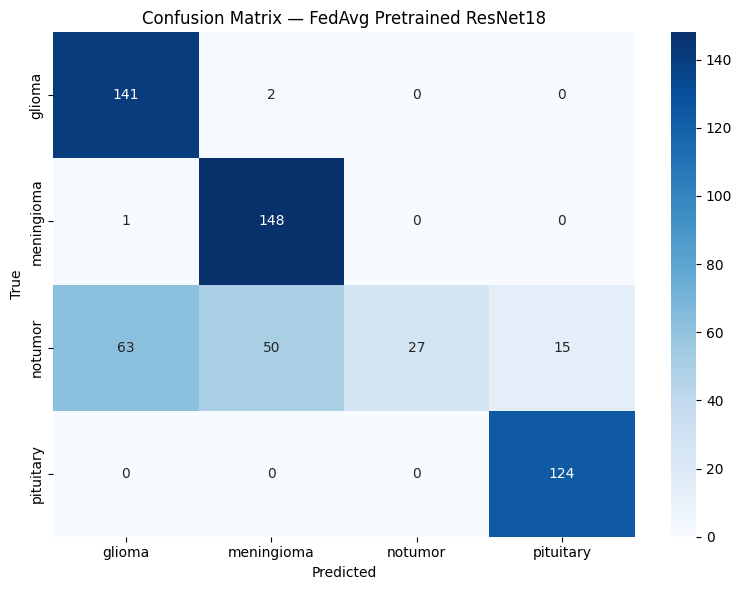


Saved confusion matrix → fedavg_pretrained_confusion_matrix.npy


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ============================================================
#     LOAD BEST FEDAVG-PRETRAINED MODEL FOR EVALUATION
# ============================================================

best_model = create_pretrained_resnet18(NUM_CLASSES)  # same builder function used in training
best_model.load_state_dict(torch.load("best_global_model_fedavg_pretrained_extreme.pth"))
best_model.to(DEVICE)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in holdout_loader:       # from your original data pipeline
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = best_model(x)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# ============================================================
#                 METRICS (ACCURACY / PRECISION / RECALL)
# ============================================================

acc = (all_preds == all_labels).mean()
prec = precision_score(all_labels, all_preds, average="macro")
rec = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print("\n📊 FEDAVG PRETRAINED — METRICS (HOLDOUT SET)")
print(f"Accuracy :  {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall   :  {rec:.4f}")
print(f"F1-Score :  {f1:.4f}")

# ============================================================
#                       CONFUSION MATRIX
# ============================================================

cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — FedAvg Pretrained ResNet18")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ============================================================
#                   SAVE CONFUSION MATRIX
# ============================================================
np.save("fedavg_pretrained_confusion_matrix.npy", cm)
print("\nSaved confusion matrix → fedavg_pretrained_confusion_matrix.npy")


In [37]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset

# ============================================================
#                    DEVICE SELECTION (MAC FIX)
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#                         CONFIG
#        FedProx + Pretrained ResNet18 (Extreme non-IID)
# ============================================================
SEED = 77
NUM_ROUNDS_FP = 30          # federated rounds
LOCAL_EPOCHS_FP = 5         # local epochs per round
LR_FP = 3e-4                # learning rate for fine-tuning
FEDPROX_MU_FP = 1e-3      # FedProx μ for extreme non-IID
BATCH_SIZE_FP = 32

NUM_CLIENTS = len(client_indices)         # from your partition code
NUM_CLASSES = len(train_dataset.classes)  # number of classes

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#                   CLIENT LOADERS (IN-MEMORY)
# ============================================================
client_loaders_fp = {}
for k in range(NUM_CLIENTS):
    subset_k = Subset(train_dataset, client_indices[k])
    client_loaders_fp[k] = DataLoader(
        subset_k,
        batch_size=BATCH_SIZE_FP,
        shuffle=True,
        num_workers=0
    )

# Holdout/test loader (10% random split from full train_dataset)
holdout_indices_fp = np.random.choice(
    len(train_dataset),
    int(0.1 * len(train_dataset)),
    replace=False
)
holdout_loader_fp = DataLoader(
    Subset(train_dataset, holdout_indices_fp),
    batch_size=BATCH_SIZE_FP,
    shuffle=False,
    num_workers=0
)

# ============================================================
#      RESNET18 (PRETRAINED) WITH FREEZING STRATEGY
# ============================================================
def create_pretrained_resnet18_fedprox(num_classes: int) -> nn.Module:
    """
    ResNet18 with ImageNet weights.
    Freeze: conv1, bn1, layer1, layer2
    Train : layer3, layer4, fc
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for p in model.conv1.parameters():
        p.requires_grad = False
    for p in model.bn1.parameters():
        p.requires_grad = False
    for p in model.layer1.parameters():
        p.requires_grad = False
    for p in model.layer2.parameters():
        p.requires_grad = False

    # Ensure deeper layers are trainable
    for p in model.layer3.parameters():
        p.requires_grad = True
    for p in model.layer4.parameters():
        p.requires_grad = True

    # Replace classifier head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model

# ============================================================
#                   TRAINING FUNCTIONS
# ============================================================
def train_one_epoch_fp(model, loader, device, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        loss = crit_ce(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc": total_correct / max(total, 1)
    }


@torch.no_grad()
def evaluate_fp(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc": total_correct / max(total, 1)
    }

# ============================================================
#               FEDPROX LOCAL TRAIN FUNCTION
# ============================================================
def train_fedprox_epoch_fp(model, loader, device, optimizer, global_params, mu):
    """
    One local epoch of FedProx training.
    global_params: dict[name -> tensor] from global model parameters.
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce(logits, y)

        # Proximal term
        prox_term = 0.0
        for name, param in model.named_parameters():
            if param.requires_grad:  # only penalize trainable params
                prox_term = prox_term + ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc": total_correct / max(total, 1)
    }

# ============================================================
#             INITIALIZE GLOBAL MODEL FOR FEDPROX
# ============================================================
global_model_fp = create_pretrained_resnet18_fedprox(NUM_CLASSES).to(DEVICE)

best_global_acc_fp = -1.0
best_global_state_fp = None

# Metrics history (unique for this experiment)
fedprox_pretrained_history_extreme = {
    "round": [],
    "holdout": [],                # list of dicts {"loss":..., "acc":...}
    "clients": {k: [] for k in range(NUM_CLIENTS)}  # each is list over rounds
}

# ============================================================
#                     FEDPROX MAIN LOOP
# ============================================================
for rnd in range(NUM_ROUNDS_FP):
    print(f"\n🔁 -------- FedProx (Pretrained) Round {rnd+1}/{NUM_ROUNDS_FP} --------")
    local_states = []

    # Cache global parameters for proximal term
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_fp.named_parameters()
    }

    # ---------- LOCAL TRAINING ----------
    for k in range(NUM_CLIENTS):
        local_model_fp = copy.deepcopy(global_model_fp).to(DEVICE)

        # Train only params that require grad
        optimizer = optim.Adam(
            (p for p in local_model_fp.parameters() if p.requires_grad),
            lr=LR_FP
        )

        for _ in range(LOCAL_EPOCHS_FP):
            train_metrics_k = train_fedprox_epoch_fp(
                local_model_fp,
                client_loaders_fp[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU_FP
            )

        # Store local state dict (on CPU)
        local_states.append({
            key: val.cpu() for key, val in local_model_fp.state_dict().items()
        })

        # Evaluate on local client data (optional – here on train loader)
        client_metric = evaluate_fp(local_model_fp, client_loaders_fp[k], DEVICE)
        fedprox_pretrained_history_extreme["clients"][k].append(client_metric)
        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")

    # ---------- FEDERATED AVERAGING ----------
    new_state = {}
    for key in global_model_fp.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        # average only floating tensors
        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            # copy from first client for int / bool tensors
            new_state[key] = stacked[0]

    global_model_fp.load_state_dict(new_state)

    # ---------- GLOBAL EVALUATION ----------
    holdout_metric = evaluate_fp(global_model_fp, holdout_loader_fp, DEVICE)
    fedprox_pretrained_history_extreme["round"].append(rnd + 1)
    fedprox_pretrained_history_extreme["holdout"].append(holdout_metric)

    print(f"🌐 FedProx Pretrained Global | Loss: {holdout_metric['loss']:.4f} | "
          f"Acc: {holdout_metric['acc']:.4f}")

    # ---------- SAVE BEST MODEL ----------
    if holdout_metric["acc"] > best_global_acc_fp:
        best_global_acc_fp = holdout_metric["acc"]
        best_global_state_fp = copy.deepcopy(global_model_fp.state_dict())
        print(f"💾 New Best FedProx-Pretrained Model Saved! Acc = {best_global_acc_fp:.4f}")

# ============================================================
#                 SAVE BEST FEDPROX MODEL + METRICS
# ============================================================
if best_global_state_fp is not None:
    torch.save(best_global_state_fp, "best_fedprox_pretrained_extreme.pth")
    print(f"\n✅ Best FedProx-pretrained model saved to best_fedprox_pretrained_extreme.pth "
          f"(Acc = {best_global_acc_fp:.4f})")
else:
    print("\n⚠️ No improvement — no FedProx-pretrained model saved.")

# Save metrics history as numpy file for plotting later
np.save("fedprox_pretrained_history.npy", fedprox_pretrained_history_extreme, allow_pickle=True)
print("📊 Metrics history saved to fedprox_pretrained_history.npy")


🚀 Using Apple Silicon GPU (MPS)

🔁 -------- FedProx (Pretrained) Round 1/30 --------
  Client 0 | Acc: 1.0000
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 1.0000
  Client 3 | Acc: 1.0000
🌐 FedProx Pretrained Global | Loss: 1.0029 | Acc: 0.6357
💾 New Best FedProx-Pretrained Model Saved! Acc = 0.6357

🔁 -------- FedProx (Pretrained) Round 2/30 --------
  Client 0 | Acc: 1.0000
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 1.0000
  Client 3 | Acc: 1.0000
🌐 FedProx Pretrained Global | Loss: 0.9084 | Acc: 0.6112

🔁 -------- FedProx (Pretrained) Round 3/30 --------
  Client 0 | Acc: 1.0000
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 1.0000
  Client 3 | Acc: 1.0000
🌐 FedProx Pretrained Global | Loss: 0.8421 | Acc: 0.6515
💾 New Best FedProx-Pretrained Model Saved! Acc = 0.6515

🔁 -------- FedProx (Pretrained) Round 4/30 --------
  Client 0 | Acc: 0.9991
  Client 1 | Acc: 1.0000
  Client 2 | Acc: 1.0000
  Client 3 | Acc: 1.0000
🌐 FedProx Pretrained Global | Loss: 0.7946 | Acc: 0.6708
💾 New Best FedPr

Loaded rounds: 30

================ FEDPROX PRETRAINED FINAL METRICS ================
Accuracy:  0.8757
Loss:      0.3190
Precision: 0.8993
Recall:    0.8852
F1 Score:  0.8714


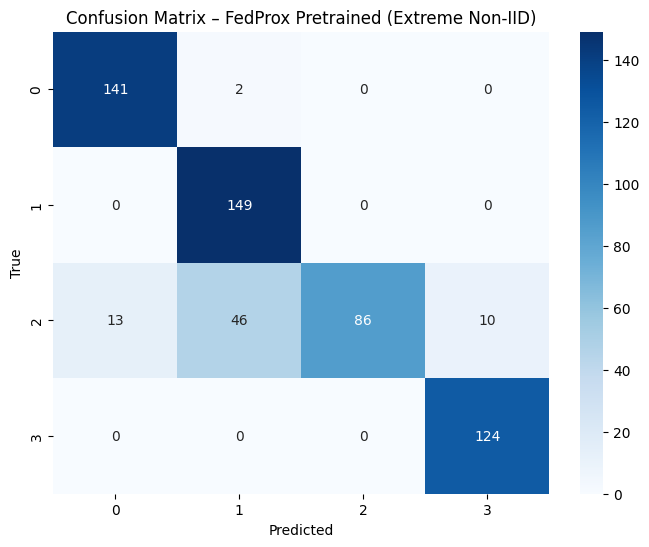

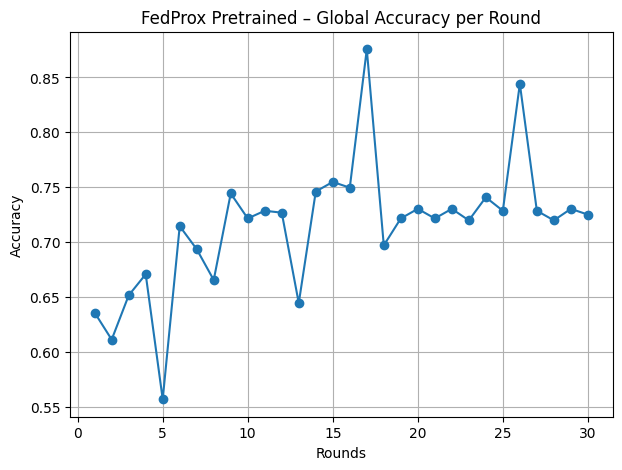

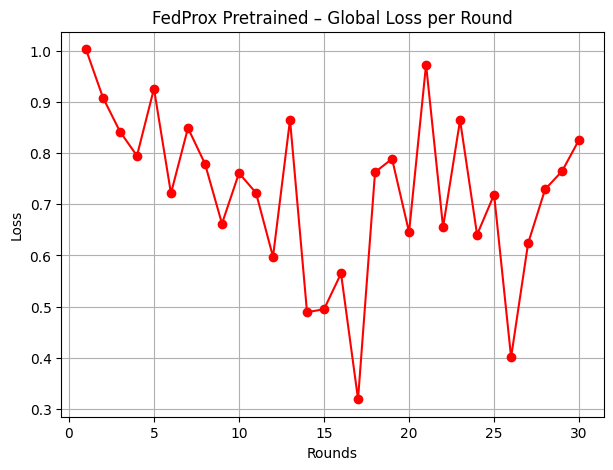

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

# ------------------------------------------------------------
# 1. Load history + best model
# ------------------------------------------------------------
history = np.load("fedprox_pretrained_history.npy", allow_pickle=True).item()

rounds = history["round"]
global_metrics = history["holdout"]      # list of dicts: {"acc":..., "loss":...}

accs = [m["acc"] for m in global_metrics]
losses = [m["loss"] for m in global_metrics]

print("Loaded rounds:", len(rounds))


# ------------------------------------------------------------
# 2. Re-load model architecture (same as training)
# ------------------------------------------------------------
def create_pretrained_resnet18_fedprox(num_classes: int):
    from torchvision import models
    import torch.nn as nn

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters(): p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Allow training in late layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace classifier head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, NUM_CLASSES)

    return model


# ------------------------------------------------------------
# 3. Load best model
# ------------------------------------------------------------
device = DEVICE
best_model_fp = create_pretrained_resnet18_fedprox(NUM_CLASSES).to(device)
best_model_fp.load_state_dict(torch.load("best_fedprox_pretrained_extreme.pth", map_location=device))
best_model_fp.eval()


# ------------------------------------------------------------
# 4. Evaluate on holdout set
# ------------------------------------------------------------
all_preds = []
all_labels = []

crit_ce = torch.nn.CrossEntropyLoss()

total_loss = 0
total_samples = 0

with torch.no_grad():
    for x, y in holdout_loader_fp:
        x, y = x.to(device), y.to(device)
        logits = best_model_fp(x)

        loss = crit_ce(logits, y)
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

        preds = logits.argmax(1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

final_acc = (all_preds == all_labels).mean()
final_loss = total_loss / total_samples

precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print("\n================ FEDPROX PRETRAINED FINAL METRICS ================")
print(f"Accuracy:  {final_acc:.4f}")
print(f"Loss:      {final_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("==================================================================")


# ------------------------------------------------------------
# 5. Confusion Matrix
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – FedProx Pretrained (Extreme Non-IID)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ------------------------------------------------------------
# 6. Plot Accuracy Curve
# ------------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.plot(rounds, accs, marker="o")
plt.title("FedProx Pretrained – Global Accuracy per Round")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


# ------------------------------------------------------------
# 7. Plot Loss Curve
# ------------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.plot(rounds, losses, marker="o", color="red")
plt.title("FedProx Pretrained – Global Loss per Round")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [39]:
import torch
import random

# pick 12 random samples from the holdout loader
samples = []
labels = []

for batch_x, batch_y in holdout_loader:
    for i in range(len(batch_x)):
        samples.append(batch_x[i])
        labels.append(batch_y[i])
        if len(samples) >= 12:
            break
    if len(samples) >= 12:
        break

samples = torch.stack(samples).to(DEVICE)
labels = torch.tensor(labels).to(DEVICE)



====== FedAvg Extreme Results ======
acc: 0.7706
loss: 0.5656
precision: 0.8300
recall: 0.7884
f1: 0.7245

====== FedProx Extreme Results ======
acc: 0.8757
loss: 0.3190
precision: 0.8993
recall: 0.8852
f1: 0.8714


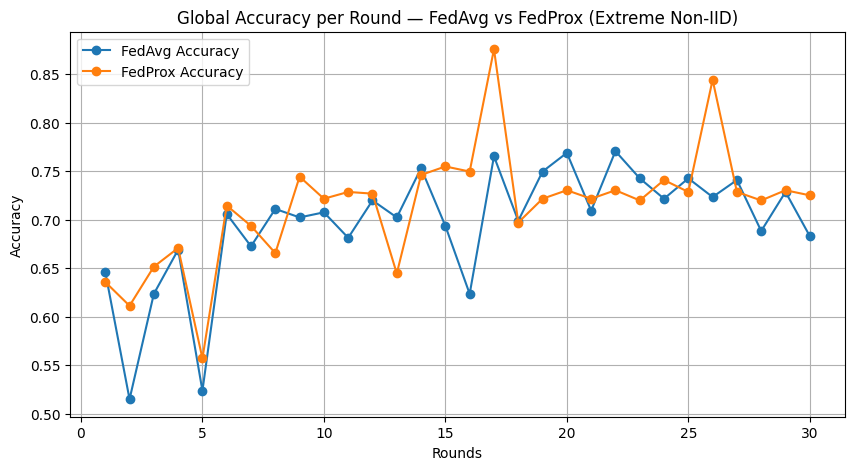

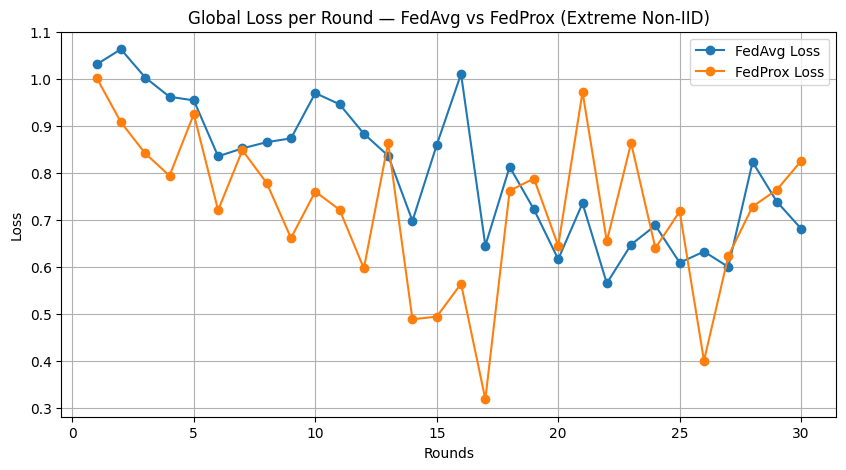

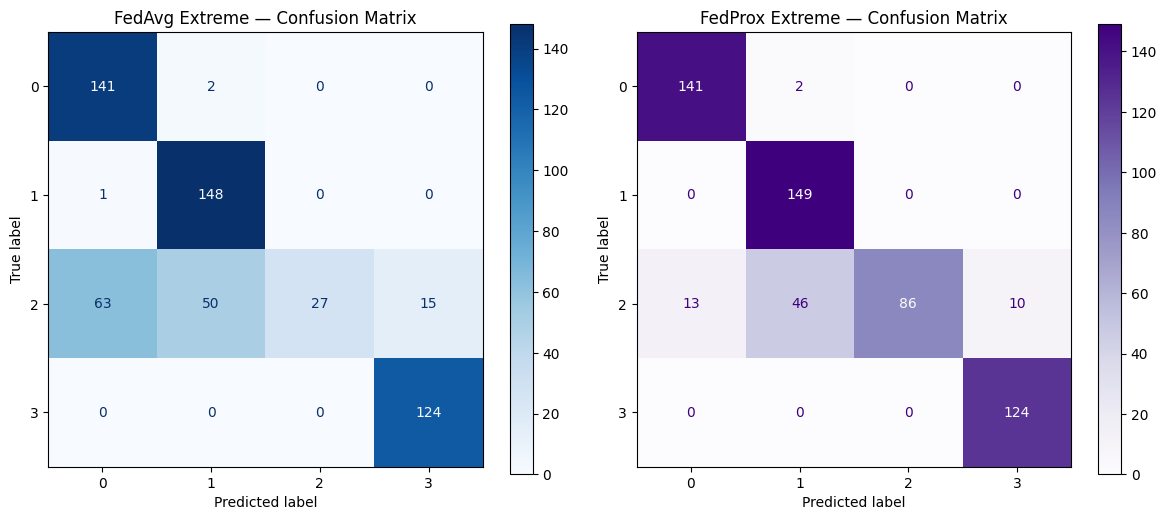

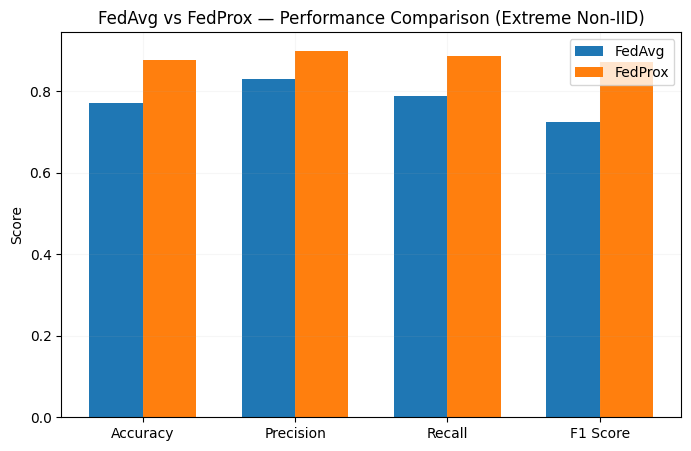

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import torch.nn as nn
from torchvision import models

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
#                 MODEL BUILDER (NO PRETRAIN)
# ============================================================
def create_resnet18(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model


# ============================================================
#                 LOAD METRICS HISTORY
# ============================================================
fedavg_hist = np.load("metrics_history_fedavg_pretrained_extreme.npy",
                      allow_pickle=True).item()
fedprox_hist = np.load("fedprox_pretrained_history.npy",
                       allow_pickle=True).item()

# Extract for plotting
rounds_fa = fedavg_hist["round"]
rounds_fp = fedprox_hist["round"]

acc_fa = [x["acc"] for x in fedavg_hist["holdout"]]
acc_fp = [x["acc"] for x in fedprox_hist["holdout"]]

loss_fa = [x["loss"] for x in fedavg_hist["holdout"]]
loss_fp = [x["loss"] for x in fedprox_hist["holdout"]]

# ============================================================
#        LOAD THE TWO TRAINED MODELS FOR FINAL EVALUATION
# ============================================================
NUM_CLASSES = len(train_dataset.classes)

fedavg_model = create_resnet18(NUM_CLASSES).to(DEVICE)
fedavg_model.load_state_dict(torch.load("best_global_model_fedavg_pretrained_extreme.pth"))
fedavg_model.eval()

fedprox_model = create_resnet18(NUM_CLASSES).to(DEVICE)
fedprox_model.load_state_dict(torch.load("best_fedprox_pretrained_extreme.pth"))
fedprox_model.eval()

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#                   EVALUATION FUNCTION
# ============================================================
def evaluate_full(model, loader):
    model.eval()
    total_loss = 0
    total = 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x)
            loss = crit_ce(logits, y)

            total_loss += loss.item() * x.size(0)
            total += x.size(0)

            preds = logits.argmax(1)
            preds_all.append(preds.cpu())
            labels_all.append(y.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()

    return {
        "acc": (preds_all == labels_all).mean(),
        "loss": total_loss / total,
        "precision": precision_score(labels_all, preds_all, average='macro', zero_division=0),
        "recall": recall_score(labels_all, preds_all, average='macro', zero_division=0),
        "f1": f1_score(labels_all, preds_all, average='macro', zero_division=0),
        "preds": preds_all,
        "labels": labels_all
    }


# ============================================================
#           FINAL METRICS FROM HOLDOUT SET
# ============================================================
fa_final = evaluate_full(fedavg_model, holdout_loader_fp)
fp_final = evaluate_full(fedprox_model, holdout_loader_fp)

print("\n====== FedAvg Extreme Results ======")
for k, v in fa_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")

print("\n====== FedProx Extreme Results ======")
for k, v in fp_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")


# ============================================================
#          📈 GLOBAL ACCURACY & LOSS PLOTS
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(rounds_fa, acc_fa, label="FedAvg Accuracy", marker='o')
plt.plot(rounds_fp, acc_fp, label="FedProx Accuracy", marker='o')
plt.xlabel("Rounds"); plt.ylabel("Accuracy")
plt.title("Global Accuracy per Round — FedAvg vs FedProx (Extreme Non-IID)")
plt.grid(); plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(rounds_fa, loss_fa, label="FedAvg Loss", marker='o')
plt.plot(rounds_fp, loss_fp, label="FedProx Loss", marker='o')
plt.xlabel("Rounds"); plt.ylabel("Loss")
plt.title("Global Loss per Round — FedAvg vs FedProx (Extreme Non-IID)")
plt.grid(); plt.legend()
plt.show()


# ============================================================
#    🤝 CONFUSION MATRICES SIDE BY SIDE
# ============================================================
cm_fa = confusion_matrix(fa_final["labels"], fa_final["preds"])
cm_fp = confusion_matrix(fp_final["labels"], fp_final["preds"])

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(cm_fa).plot(ax=ax[0], cmap="Blues")
ConfusionMatrixDisplay(cm_fp).plot(ax=ax[1], cmap="Purples")

ax[0].set_title("FedAvg Extreme — Confusion Matrix")
ax[1].set_title("FedProx Extreme — Confusion Matrix")
plt.tight_layout()
plt.show()


# ============================================================
#   📊 BAR PLOT — ACC, PRECISION, RECALL, F1
# ============================================================
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
fa_vals = [fa_final["acc"], fa_final["precision"], fa_final["recall"], fa_final["f1"]]
fp_vals = [fp_final["acc"], fp_final["precision"], fp_final["recall"], fp_final["f1"]]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, fa_vals, w, label="FedAvg")
plt.bar(x + w/2, fp_vals, w, label="FedProx")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("FedAvg vs FedProx — Performance Comparison (Extreme Non-IID)")
plt.legend()
plt.grid(alpha=0.1)
plt.show()
